# Proteogenomics database generation using py-pgatk


This notebook presents commands in `py-pgatk` to:
- download data from various sources including ENSEMBL for reference files, COSMIC & cBioPortal for cancer mutations, and gnomAD & ENSEMBL for population variants.
- generate protein databases using the downloaded files or from custom files (mutations in VCF and transcripts in GTF)
- explore the database content (number of proteins and overlaps in tryptic peptides between various protein categories)

`py-pgatk` is implemented in `Python` and is available here: https://github.com/bigbio/py-pgatk. 
The commands are documented here: https://pgatk.readthedocs.io/en/latest/pypgatk.html.
The tools are also builtin to a nextflow workflow: https://nf-co.re/pgdb.

The easiset way to run this notebook is by installing conda and creating an environment for installing the required packages. 


# Part 1: Setup the environment

### Get notebook and data
Download this this notebook and associated (any) data in this directory to your computer

### Browse to your working directory and start Jupyter from there using
`jupyter-notebook`


### Install and Download configuration files and 

#### Import / install required libraries

In [1]:
import os
import shutil
import sys
from collections import Counter

try:
    from Bio import SeqIO
except ModuleNotFoundError:
    !pip install biopython

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip install matplotlib

try:
    import pypgatk
except ModuleNotFoundError:
    !pip install pypgatk

#### Get Configuaration Files

In [2]:
if not os.path.isdir('config'):
    os.system('wget https://github.com/bigbio/py-pgatk/archive/refs/tags/v0.0.20.zip')
    os.system('unzip v0.0.20.zip')
    shutil.copytree('py-pgatk-0.0.20/pypgatk/config', 'config')
if os.path.isdir('config'):
    print('the files are available in config/ in the current directory:\n ', os.getcwd())
try:
    shutil.rmtree('py-pgatk-0.0.20')
except FileNotFoundError:
    pass
try:
    os.remove('v0.0.20.zip')
except FileNotFoundError:
    pass

the files are available in config/ in the current directory:
  /Users/husen/Documents/Karolinska Institutet/GRP_LehtioLab_bioinformatics_brains - General/ProteoWorks/workshop_pgdb


### Install gffread v.0.12.7 
This tool is needed to convert GTF (gene-transript annotation file) to FASTA (DNA sequence)

In [3]:
if not os.path.isfile('gffread'):
    print('Downloading gffread')
    if 'linux' in sys.platform:
        os.system('wget https://github.com/gpertea/gffread/releases/download/v0.12.7/gffread-0.12.7.Linux_x86_64.tar.gz')
        os.system('tar -xvzf gffread-0.12.7.Linux_x86_64.tar.gz')
        shutil.move('gffread-0.12.7.Linux_x86_64/gffread', 'gffread')
    elif 'darwin' in sys.platform:
        os.system('wget https://github.com/gpertea/gffread/releases/download/v0.12.7/gffread-0.12.7.OSX_x86_64.tar.gz')
        os.system('tar -xvzf gffread-0.12.7.OSX_x86_64.tar.gz')
        shutil.move('gffread-0.12.7.OSX_x86_64/gffread', 'gffread')
    else:
        print('SORRY: only Linux and MAC are supported, maybe you need to try manually installing gffread')
try:
    shutil.rmtree('gffread-0.12.7.Linux_x86_64')
    os.remove('gffread-0.12.7.Linux_x86_64.tar.gz')
except FileNotFoundError:
    pass
try:
    shutil.rmtree('gffread-0.12.7.OSX_x86_64')
    os.remove('gffread-0.12.7.OSX_x86_64.tar.gz')
except FileNotFoundError:
    pass
if os.path.isfile('gffread'):
    print('gffread is ready to be used')

gffread is ready to be used


#### Before begining, let's test if pypgatk is working, you should see a help message that lists the existing commands

In [4]:
!pypgatk_cli.py -h

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
Usage: pypgatk_cli.py [OPTIONS] COMMAND [ARGS]...

  This is the main tool that give access to all commands and options
  provided by the pypgatk

Options:
  -h, --help  Show this message and exit.

Commands:
  cbioportal-downloader    Command to download the the cbioportal studies
  cbioportal-to-proteindb  Command to translate cbioportal mutation data into
                           proteindb
  cosmic-downloader        Command to download the cosmic mutation database
  cosmic-to-proteindb      Command to translate Cosmic mutation data into
                           proteindb
  dnaseq-to-proteindb      Generate peptides based on DNA sequences
  ensembl-check            Command to check ensembl database for stop codons,
                           gaps
  ensembl-downloader       Command to download the ensembl information
  generate-decoy           Create decoy protein sequence

# Part 2: DNA to Protein

In this part we will use the `dnaseq-to-proteindb` command to translate DNA sequences in fasta format to protein. We will also show how to convert a GTF obtained from a reference assembly or from a RNA-seq to DNA sequences and then protein sequence.

## Download relevant files

First we need to specify what files to download from the reference assembly. By default, `ensembl-downloader` downloads all files. The flags below can be used to ignore some files, e.g --skip_dna will skip downloading the reference DNA sequence, etc.

* Note: versions prior to v0.0.20 don't have the feature to download the DNA reference assembly. IF you are using an older version you need to download the DNA fasta manually, uncomment the commands given below to perform this step.

### Check the flags below to know what flags to use.

In [5]:
!pypgatk_cli.py ensembl-downloader -h

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
Usage: pypgatk_cli.py ensembl-downloader [OPTIONS]

  This tool enables to download from enseml ftp the FASTA and GTF files

Options:
  -c, --config_file TEXT          Configuration file for the ensembl data
                                  downloader pipeline
  -o, --output_directory TEXT     Output directory for the peptide databases
  -fp, --folder_prefix_release TEXT
                                  Output folder prefix to download the data
  -t, --taxonomy TEXT             Taxonomy identifiers (comma separated list
                                  can be given) that will be use to download
                                  the data from Ensembl
  -l, --list_taxonomies           Print the list of all the taxonomies in
                                  ENSEMBL (https://www.ensembl.org)
  -sg, --skip_gtf                 Skip the GTF file during the download
  -sp, --skip_p


#### Get taxonomy ID for the species of interest
However, as shown above we need to specify a taxonomy number in order to get files from a reference assembly for our species of interest. 

Can you find the taxonomy ID for homo sapiens using the following command?

In [ ]:
!pypgatk_cli.py ensembl-downloader -c config/ensembl_downloader_config.yaml -l -sv -sg -sp -sc -sd -sn 

Let's download reference files except VCF (variants) for `Meleagris_gallopavo.Turkey` (taxonomy id: 9103) into a folder named ensembl_files

In [7]:
!pypgatk_cli.py ensembl-downloader -c config/ensembl_downloader_config.yaml -t 9103 -o ensembl_files --skip_vcf

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
DEBUG:pypgatk.toolbox.general:Files downloaded -- ensembl_files/Meleagris_gallopavo.Turkey_5.1.pep.all.fa,ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.gtf,ensembl_files/Meleagris_gallopavo.Turkey_5.1.cds.all.fa,ensembl_files/Meleagris_gallopavo.Turkey_5.1.cdna.all.fa,ensembl_files/Meleagris_gallopavo.Turkey_5.1.ncrna.fa,ensembl_files/Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa
INFO:Main Pipeline Ensembl Downloader:Pipeline Finish !!!


Check the contents of the ensembl_files on your computer system, you should see the following files downloaded:

In [8]:
os.listdir('ensembl_files')

['Meleagris_gallopavo.Turkey_5.1.106.gtf',
 'Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa',
 'Meleagris_gallopavo.Turkey_5.1.pep.all.fa',
 'Meleagris_gallopavo.Turkey_5.1.ncrna.fa',
 'Meleagris_gallopavo.Turkey_5.1.cds.all.fa',
 'Meleagris_gallopavo.Turkey_5.1.cdna.all.fa']

#### Convert GTF (can be reference or custom from RNA-seq) to DNA sequences
Although the cdna.fa and ncrna.fa files can be used as reference DNA, but we wull use  GTF since it provides more flexibility to select desired transcript types. Also, when running your own RNA-seq experiments you usually get a GTF file as a final output therefore it is better to learn how to translate transcripts starting from a GTF file.

However, since the `dnaseq-to-proteindb` tool only accepts FASTA files as input, we first need to convert the GTF into FASTA using gffread that is a separate tool.


In [9]:
if not os.path.isfile('ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa'):
    !./gffread -F -w ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa -g ensembl_files/Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.gtf
if os.path.isfile('ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa'):
    print("\nGenerated: {} transcript sequences from the GTF file".format(
        len(list(SeqIO.index('ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa', "fasta").keys()))))

FASTA index file ensembl_files/Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa.fai created.

Generated: 30708 transcript sequences from the GTF file


Now that we have the DNA fasta file ready to be used, let's take a look at the parameters that can be applied:

In [10]:
!pypgatk_cli.py dnaseq-to-proteindb  -h

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
Usage: pypgatk_cli.py dnaseq-to-proteindb [OPTIONS]

Options:
  -c, --config_file TEXT          Configuration to perform conversion between
                                  ENSEMBL Files
  --input_fasta TEXT              Path to sequences fasta
  --translation_table INTEGER     Translation Table (default 1)
  --num_orfs INTEGER              Number of ORFs (default 3)
  --num_orfs_complement INTEGER   Number of ORFs from the reverse side
                                  (default 0)
  --output_proteindb TEXT         Output file name, exits if already exists
  -p, --var_prefix TEXT           String to add before the variant peptides
  --skip_including_all_cds        By default any transcript that has a defined
                                  CDS will be translated, this option disables
                                  this features instead it only depends on the
             

#### Generate a protein database from lncRNAs only
*Use the include_biotypes flag to specify what kind of transcripts should be translated. See ensembl biotypes: http://www.ensembl.org/info/genome/genebuild/biotypes.html

In [11]:
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb lncRNAs.fa --skip_including_all_cds --var_prefix lncRNA_ --include_biotypes lncRNA --output_proteindb lncRNAs.fa

print("\nGenerated:", Counter([x.split('_')[0] for x in list(SeqIO.index('lncRNAs.fa', "fasta").keys())]).items())


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
/Users/husen/opt/anaconda3/envs/pygatk/lib/python3.8/site-packages/Bio/Seq.py:2606: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn("Partial codon, len(sequence) not a multiple of three. "

Generated: dict_items([('lncRNA', 5109)])


#### Generate protein database from other non-coding RNAs

In [12]:
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb ncRNAs.fa --skip_including_all_cds --var_prefix ncRNA_ --include_biotypes miRNA,miscRNA,piRNA,rRNA,siRNA,snRNA,snoRNA,tRNA,vaultRNA

print("\nGenerated:", Counter([x.split('_')[0] for x in list(SeqIO.index('ncRNAs.fa', "fasta").keys())]).items())


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
/Users/husen/opt/anaconda3/envs/pygatk/lib/python3.8/site-packages/Bio/Seq.py:2606: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn("Partial codon, len(sequence) not a multiple of three. "

Generated: dict_items([('ncRNA', 1500)])


#### Generate protein database from alternative reading frames of coding sequences

In [13]:
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb altORFs.fa --skip_including_all_cds --var_prefix altORF_ --include_biotypes altORFs

print("\nGenerated:", Counter([x.split('_')[0] for x in list(SeqIO.index('altORFs.fa', "fasta").keys())]).items())


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
/Users/husen/opt/anaconda3/envs/pygatk/lib/python3.8/site-packages/Bio/Seq.py:2606: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn("Partial codon, len(sequence) not a multiple of three. "

Generated: dict_items([('altORF', 84885)])


#### Generate a protein database from pseudogenes? 

In [14]:
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb pesuedogenes.fa --skip_including_all_cds --var_prefix pesuedogene_ --include_biotypes pseudogene,processed_pseudogene

print("\nGenerated:", Counter([x.split('_')[0] for x in list(SeqIO.index('pesuedogenes.fa', "fasta").keys())]).items())


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
/Users/husen/opt/anaconda3/envs/pygatk/lib/python3.8/site-packages/Bio/Seq.py:2606: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn("Partial codon, len(sequence) not a multiple of three. "

Generated: dict_items([('pesuedogene', 477)])


### Concatenate the generated protein databases with reference proteome

In [15]:
!cat lncRNAs.fa pesuedogenes.fa ncRNAs.fa altORFs.fa ensembl_files/Meleagris_gallopavo.Turkey_5.1.pep.all.fa > proteins.fa

Counter([x.replace('ENS','Can_ENS').split('_')[0] for x in list(SeqIO.index('proteins.fa', "fasta").keys())]).items()


dict_items([('lncRNA', 5109), ('pesuedogene', 477), ('ncRNA', 1500), ('altORF', 84885), ('Can', 28295)])

### Generate decoy protein sequences

In [16]:
!pypgatk_cli.py generate-decoy -c config/protein_decoy.yaml -in proteins.fa -out decoys.fa

Counter([x.replace('ENS','Can_ENS').split('_')[0] for x in list(SeqIO.index('decoys.fa', "fasta").keys())]).items()


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
Number of target peptides: 1942273 and Decoy Peptides: 1960607
% Target peptides 49.8
% Decoy peptides 50.2
Number of peptides in Target and Decoy 12250, Percentage 0.3
Aminoacid composition rate for A (Target/Decoy) = 1.0 
Aminoacid composition rate for C (Target/Decoy) = 1.0 
Aminoacid composition rate for D (Target/Decoy) = 1.0 
Aminoacid composition rate for E (Target/Decoy) = 1.0 
Aminoacid composition rate for F (Target/Decoy) = 1.0 
Aminoacid composition rate for G (Target/Decoy) = 1.0 
Aminoacid composition rate for H (Target/Decoy) = 1.0 
Aminoacid composition rate for I (Target/Decoy) = 1.0 
Aminoacid composition rate for K (Target/Decoy) = 1.0 
Aminoacid composition rate for L (Target/Decoy) = 1.0 
Aminoacid composition rate for M (Target/Decoy) = 1.0 
Aminoacid composition rate for N (Target/Decoy) = 1.0 
Aminoacid composition rate for P (Target/Decoy) = 1.0 
Aminoa

dict_items([('lncRNA', 5109), ('DECOY', 120266), ('pesuedogene', 477), ('ncRNA', 1500), ('altORF', 84885), ('Can', 28295)])

#### Perform six-frame translation on DNA seqyence

In [17]:
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --skip_including_all_cds --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb sixframes.fa --var_prefix sixframe_  --num_orfs 3 --num_orfs_complement 3 --include_biotypes all

Counter([x.split('_')[0] for x in list(SeqIO.index('sixframes.fa', "fasta").keys())]).items()


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
/Users/husen/opt/anaconda3/envs/pygatk/lib/python3.8/site-packages/Bio/Seq.py:2606: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn("Partial codon, len(sequence) not a multiple of three. "


dict_items([('sixframe', 184248)])

In [18]:
#function to digest proteins

def trypsin_digestion(proseq_incl_stop, miss_cleavage=0):
    "digest peptides using the tryptic rule, allowing for miss cleavages"
    all_peptides = []
    for protseq in proseq_incl_stop.split('*'):
        if len(protseq)<=0:
            continue
        peptides = []
        peptide = ''
        "remove the first K/R if in the begining of a reading frame"
        protseq_updated = protseq[0::]
        if protseq[0]=='K' or protseq[0]=='R' and len(protseq)>1:
            protseq_updated = protseq[1::]

        for c, aa in enumerate(protseq_updated):
            peptide += aa
            next_aa = ''
            try:
                next_aa = protseq_updated[c + 1]
            except IndexError:
                pass

            if aa in ['K', 'R'] and next_aa != 'P':  # for trypsin peptides
                if len(peptide) > 0:
                    peptides.append(peptide)
                peptide = ''
                continue

        if len(peptide) > 0:
            peptides.append(peptide)

        peptides_with_miss_cleavage = []
        for i in range(1, miss_cleavage + 1):
            for j, pep in enumerate(peptides):
                if j + i < len(peptides):
                    peptide = ''.join([x for x in (peptides[j:j + i + 1])])
                    peptides_with_miss_cleavage.append(peptide)

        peptides.extend(peptides_with_miss_cleavage)
        all_peptides.extend(peptides)

    return all_peptides

#### Investigate the overlap between tryptic peptides from various categories!

In [19]:
#Specify protein files to use
prot_files = ['proteins.fa']#, 'sixframes.fa']

proteins = {}
for prot_file in prot_files:
    for record in SeqIO.parse(prot_file, 'fasta'):
        prot_type = str(record.id).replace('ENS', 'Can_ENS').split('_')[0]
        try:
            proteins[prot_type].extend(trypsin_digestion(str(record.seq)))
        except KeyError:
            proteins[prot_type] = trypsin_digestion(str(record.seq))

#unify
for prot_type in proteins.keys():
    proteins[prot_type] = set(proteins[prot_type])

print('Number of tryptic peptides per type:\n', '\n'.join([k+' = '+str(len(items)) for k,items in proteins.items()]))

Number of tryptic peptides per type:
 lncRNA = 170307
pesuedogene = 32431
ncRNA = 4565
altORF = 2075045
Can = 525753


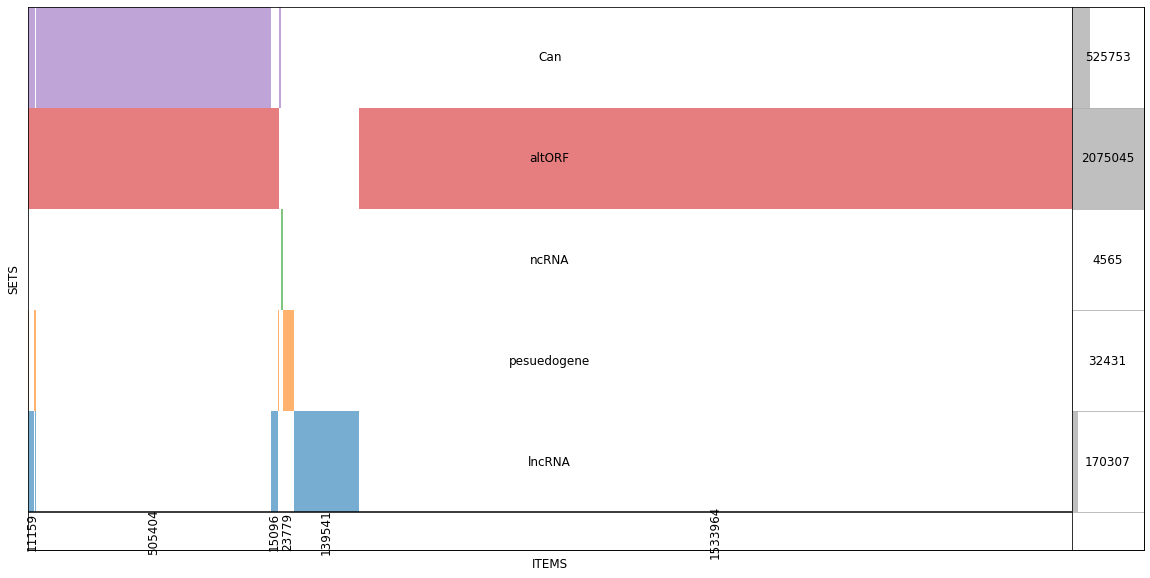

In [20]:
###Optional
#make a supervenn to plot the overlaps (takes some time)
try:
    from supervenn import supervenn
except ModuleNotFoundError:
    !pip install supervenn #does not work for some reason it looks at the base env for this package (print(sys.executable) )


labels = list(proteins.keys())
sets = [proteins[x] for x in proteins.keys()]

plt.figure(figsize=(20, 10))
supervenn(sets, labels, min_width_for_annotation=10000, rotate_col_annotations=True, 
          side_plots='right', chunks_ordering='occurrence', alternating_background= False)
plt.grid(False)
plt.savefig('baroverlap.svg')

#### Try to also show peptides from the six-frame translation? any speculations how they would look like?

In [ ]:
#write your code here to make a supervenn to show six-frame peptides and the other proteins

# Part 3: Mutations to Proteins (cBioPortal) -- To be Completed


In this part we will use the `cbioportal-downloader` and `cbioportal-to-proteindb` command to translate mutations from cancer studies in cBioPortal (https://www.cbioportal.org/).


First we need to specify what study to download from cBioPortal (see -l flag): 



Check the flags below to know what flags to use.

In [ ]:
!pypgatk_cli.py cbioportal-downloader -h

#### Download data for study ID blca_mskcc_solit_2014

In [ ]:
!pypgatk_cli.py cbioportal-downloader -c config/cbioportal_config.yaml -d blca_mskcc_solit_2014 -o ./
!tar -xzvf blca_mskcc_solit_2014.tar
#Download linking CDSs (the mutations are aligned to hg37)
!wget ftp://ftp.ensembl.org/pub/release-75/fasta/homo_sapiens/cds/Homo_sapiens.GRCh37.75.cds.all.fa.gz
!gunzip *.gz

The files are downloaded into a directory with the same name as the study ID. It contains several files but we only need the following two files:
- `data_clinical_sample.txt`: 

    This file contains metada or clinical information about each of the samples in the study
    
    
- `data_mutations.txt` (it might have slightly different names depending on the cBioPortal version): 

    This file contains the list of mutations identified in this study


#### Translate the downloaded set of mutations

First check what options you have!

In [ ]:
!pypgatk_cli.py cbioportal-to-proteindb -h

In [ ]:

!pypgatk_cli.py cbioportal-to-proteindb --config_file config/cbioportal_config.yaml --input_cds Homo_sapiens.GRCh37.75.cds.all.fa --input_mutation blca_mskcc_solit_2014/data_mutations.txt --clinical_sample_file blca_mskcc_solit_2014/data_clinical_sample.txt --output_db bladder_proteindb.fa

Counter([x.split(':')[0] for x in list(SeqIO.index('bladder_proteindb.fa', "fasta").keys())]).items()


Optionally, you can filter the samples based on any of the columns in the data_clinical_sample.txt. First, let's see what fields (clinical information) is available for the samples in this study:

In [ ]:
[x.strip() for x in open('blca_mskcc_solit_2014/data_clinical_sample.txt').readline().split('\t')]

Let's only use mutations from samples have their `Lymph Node Status` as `Positive`

In [ ]:

!pypgatk_cli.py cbioportal-to-proteindb --config_file config/cbioportal_config.yaml --input_cds Homo_sapiens.GRCh37.75.cds.all.fa --input_mutation blca_mskcc_solit_2014/data_mutations.txt --clinical_sample_file blca_mskcc_solit_2014/data_clinical_sample.txt --output_db bladder_proteindb_filtered.fa --filter_column 'LYMPH_NODE_STATUS' --accepted_values 'Positive'

Counter([x.split(':')[0] for x in list(SeqIO.index('bladder_proteindb_filtered.fa', "fasta").keys())]).items()


# Part 4: Mutations to Proteins (COSMIC)


In this part we will use the `cosmic-downloader` and `cosmic-to-proteindb` command to translate cancer mutations from COSMIC.


However, sicne downloading data from COSMIC requries registeration therefore I have pre-downloaded
- `CosmicMutantExport.tsv.gz` 
- `All_COSMIC_Genes.fasta.gz` 

The command to repeat it is sitll given below.

*takes long
Generate a protein database for each cancer type in COSMIC (--split_by_filter_column flag)


In [ ]:
#python pypgatk_cli.py cosmic-downloader -u userName -p passWord -c config/cosmic_config.yaml -o cosmic_files

!pypgatk_cli.py cosmic-to-proteindb -c config/cosmic_config.yaml -in CosmicMutantExport.tsv -fa All_COSMIC_Genes.fasta -out cosmic_proteinDB.fa --split_by_filter_column


# Part 4: Mutations/variants to Proteins


In this part we will use the `vcf-to-proteindb` command to translate mutations in VCF format to proteins. The output of genome/exome sequencing is usually a VCF file that includes the list of identified mutations.


## Download relevant files

First we need to specify genome fasta and a GTF file to download from the reference assembly. By default, `ensembl-downloader` downloads all files. The flags below can be used to ignore some files, e.g --skip_dna will skip downloading the reference DNA sequence, etc.



In [ ]:
!pypgatk_cli.py ensembl-downloader -c config/ensembl_downloader_config.yaml -t 9606 -o ensembl_files --skip_vcf

#### Check the flags that can be used for a VCF file


In [ ]:
!pypgatk_cli.py vcf-to-proteindb -h

#### Similar to above we need to generate a FASTA from the GTF -- replace the file names and uncomment the line below

In [ ]:
#gffread -F -w transcripts.fa -g genome.fa gene_annotations.gtf

#### replace the file names and uncomment the line below

In [ ]:
#!pypgatk_cli.py vcf-to-proteindb --vcf sample.vcf --input_fasta transcripts.fa --gene_annotations_gtf genes.gtf --annotation_field_name '' --output_proteindb var_peptides.fa
